<a href="https://colab.research.google.com/github/cindyhfls/NMA_DL_2021_project/blob/main/SteinGetz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [46]:
# Imports
import time
import torch
import pathlib
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset, Dataset

from tqdm.notebook import tqdm, trange
from PIL import Image

In [4]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [232]:
for i in alldat[4].keys():
  print(i)
  # print(alldat[4][i].shape)

the regions available in this recording session are{'ORB', 'SUB', 'MOs', 'DG', 'VISa', 'OLF', 'ACA', 'PL', 'CA1'}
trial number 62


([<matplotlib.lines.Line2D at 0x7f73488add50>],
 Text(0.5, 1.0, 'Neuron in CA1 at coord [6976.  1336.1 3837.5], trial 62'))

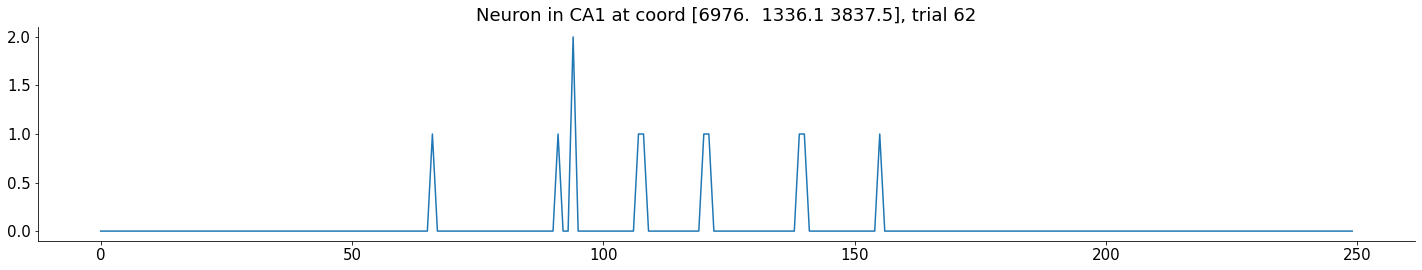

In [247]:
##### play with the data. here we remove the root data from the recordings. 


def get_session(X):
  return alldat[X]
test=get_session(4)


def root(session):
  rmrt=list(np.where(session['brain_area']=='root'))[0]
  return rmrt

rt=root(test)

def plot_spike(session,remove):

  #### remove data corresponding to root
  spike=np.delete(session['spks'],remove,axis=0)
  region=np.delete(session['brain_area'],remove,axis=0)
  print(f'the regions available in this recording session are{set(region)}')
  coord=np.delete(session['ccf'],remove,axis=0)
  #plot a random spike from given a session
  idx=np.random.randint(0,spike.shape[0])
  region=region[idx]
  coord=coord[idx] 
  sp=spike[idx]

    ##get individual trial data
  trial=np.random.randint(0,sp.shape[0])
  print(f'trial number {trial}')
  return plt.plot(sp[trial]), plt.title(f'Neuron in {region} at coord {coord}, trial {trial}')
  
plot_spike(test,rt)



the regions available in this recording session are{'MOs'}
trial number 203/254


([<matplotlib.lines.Line2D at 0x7f7348060310>],
 Text(0.5, 1.0, 'Neuron in MOs at coord [3503.4 1654.4 5330.5], trial 203'))

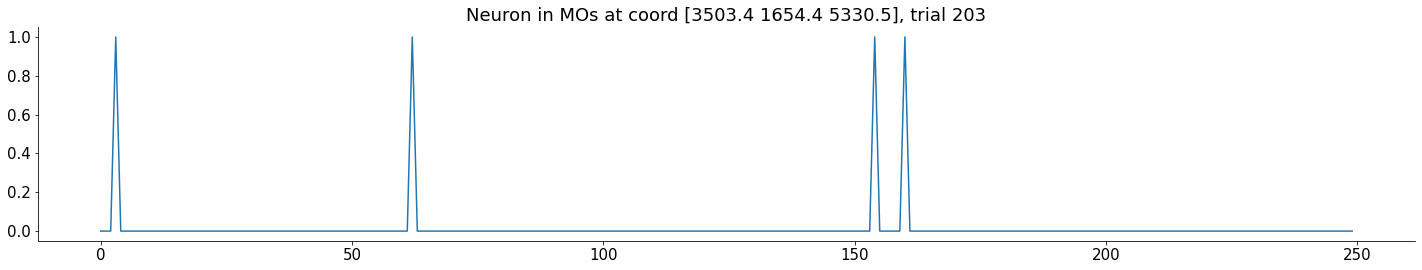

In [276]:
##### here we'll extract the neurons from only the regions we're interested in 

def get_session(X):
  return alldat[X]
test=get_session(4)


def root(session,region):
  rmrt=list(np.where(session['brain_area']!=region))[0]
  return rmrt

rt=root(test,'MOs')

def plot_spike(session,remove):

  #### remove data corresponding to root
  spike=np.delete(session['spks'],remove,axis=0)
  region=np.delete(session['brain_area'],remove,axis=0)
  print(f'the regions available in this recording session are{set(region)}')
  coord=np.delete(session['ccf'],remove,axis=0)
  #plot a random spike from given a session
  idx=np.random.randint(0,spike.shape[0])
  region=region[idx]
  coord=coord[idx] 
  sp=spike[idx]

    ##get individual trial data
  trial=np.random.randint(0,sp.shape[0])
  print(f'trial number {trial}/{spike.shape[1]}')
  return plt.plot(sp[trial]), plt.title(f'Neuron in {region} at coord {coord}, trial {trial}')
  
plot_spike(test,rt)



In [286]:
plt.plot(np.hstack(test['spks'][50]).shape

all recordings from neuron 15, in MOs


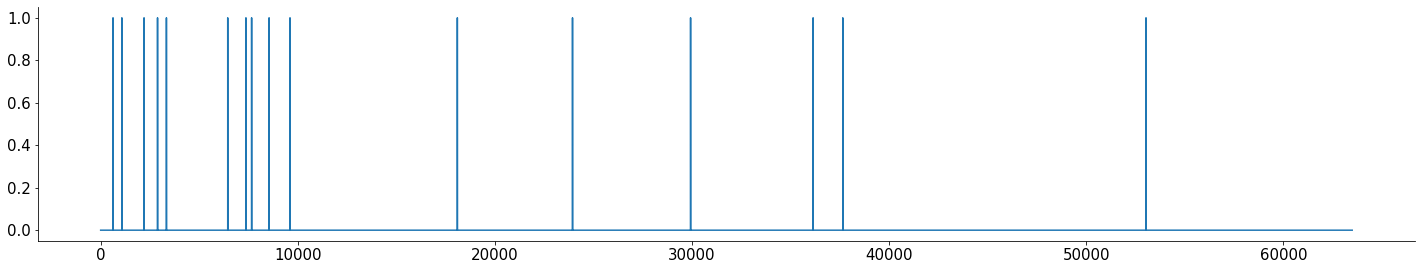

In [311]:

def plot_all_trials(session,remove):

  #### remove data corresponding to root
  spike=np.delete(session['spks'],remove,axis=0)
  region=np.delete(session['brain_area'],remove,axis=0)
  coord=np.delete(session['ccf'],remove,axis=0)
  #plot all spikes across all trials from a single neuron
  idx=np.random.randint(0,spike.shape[0])
  region=region[idx]
  coord=coord[idx] 
  sp=np.hstack(spike[idx])

    ##get individual trial data
  print(f'all recordings from neuron {idx}, in {region}')
  return plt.plot(sp)
  
plot_all_trials(test,rt)
  


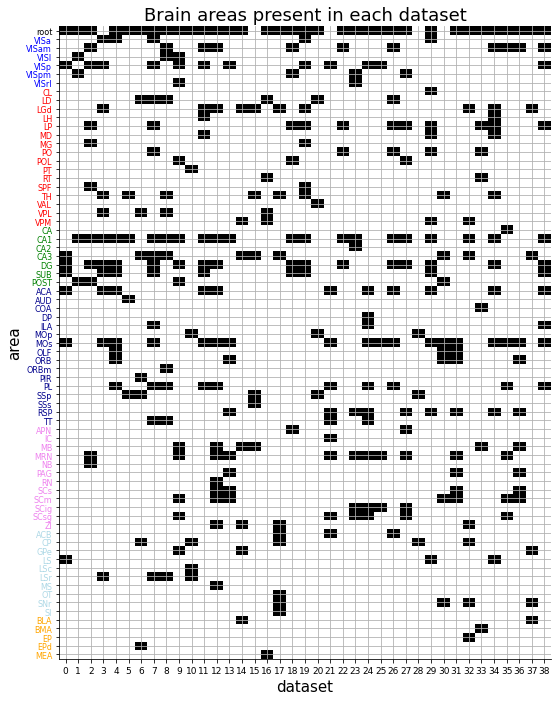

In [5]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
    yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
    for area in group:
        ytickobjs[counter].set_color(color)
        counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)